In [10]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! cp kaggle.json ~/.kaggle/

In [13]:
! chmod 600 ~/.kaggle/kaggle.json

In [14]:
! kaggle competitions download -c aptos2019-blindness-detection

aptos2019-blindness-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
! unzip /content/aptos2019-blindness-detection.zip -d /content/dataset

In [53]:
import numpy as np
import pandas as pd
from PIL import Image,ImageEnhance
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, losses
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.layers import Dropout                      
from keras.callbacks import EarlyStopping  

In [19]:
def define_trpaths(train_data, train_csv):
    filepaths = []
    labels = []
    df = pd.read_csv(train_csv)
    files = os.listdir(train_data)
    for file, i in zip(sorted(files), df['diagnosis']):
        fpath = os.path.join(train_data, file)
        filepaths.append(fpath)
        if i == 0:
            labels.append('No DR')
        elif i == 1:
            labels.append('Mild')
        elif i == 2:
            labels.append('Moderate')
        elif i == 3:
            labels.append('Severe')
        elif i == 2:
            labels.append('Proliferative DR')
        else:
            labels.append('Not Classified')
        
    return filepaths, labels

def define_trdf(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(train_data, train_csv):
    # train dataframe
    files, classes = define_trpaths(train_data, train_csv)
    df = define_trdf(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
    
    return train_df, valid_df

In [33]:
def create_gens(train_df, valid_df, train_dir):
    img_size = (224, 224)
    channels = 3
    batch_size = 32
    img_shape = (img_size[0], img_size[1], channels)
    
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    val_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', directory = train_dir, target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', directory = train_dir, target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

    return train_gen, valid_gen

In [42]:
def create_gens(train_df, valid_df, train_dir):
    img_size = (224, 224)
    channels = 3
    batch_size = 32
    img_shape = (img_size[0], img_size[1], channels)
    
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                  shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
    val_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', directory = train_dir, target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', directory = train_dir, target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

    return train_gen, valid_gen

In [43]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [44]:
train_data='/content/dataset/train_images'
train_csv='/content/dataset/train.csv'

train_df, valid_df = create_df(train_data, train_csv)

In [45]:
train_gen, valid_gen = create_gens(train_df, valid_df, train_data)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


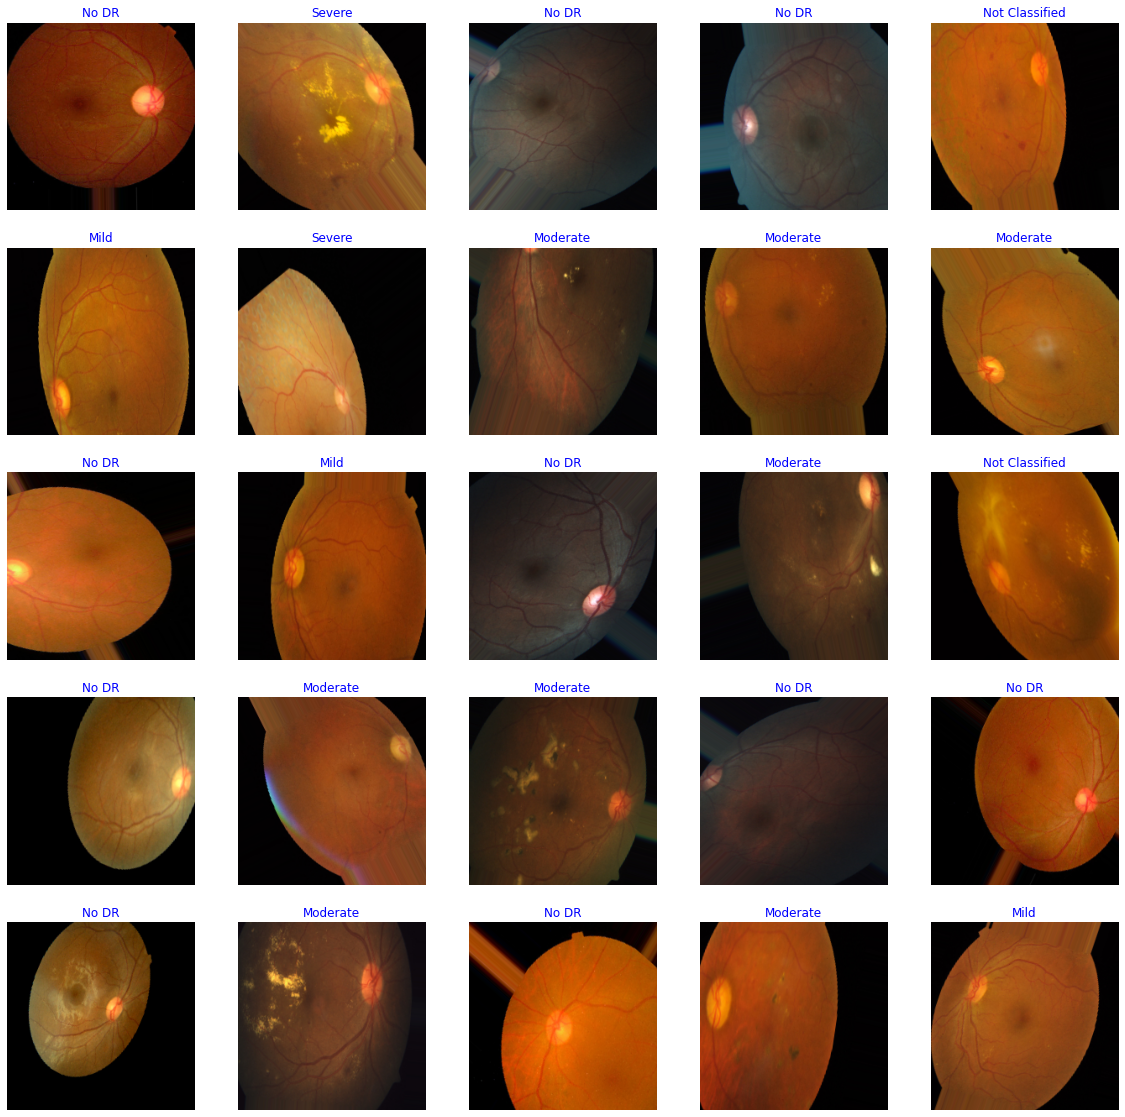

In [46]:
show_images(train_gen)

In [47]:
train_df

,filepaths,labels
639,/content/dataset/train_images/2d04cead4d3a.png,No DR
560,/content/dataset/train_images/27bab1432f61.png,Moderate
1386,/content/dataset/train_images/613bacb35c05.png,Mild
2696,/content/dataset/train_images/ba4d2c4b3039.png,Not Classified
1532,/content/dataset/train_images/6c250a30593b.png,Not Classified
...,...,...
1474,/content/dataset/train_images/6735931000ec.png,Severe
2240,/content/dataset/train_images/9d9bfefa809c.png,Moderate
18,/content/dataset/train_images/0151781fe50b.png,No DR
2657,/content/dataset/train_images/b835b6e31a59.png,No DR


In [48]:
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

In [49]:
base_model=VGG19(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable=False

80134624/80134624 [==============================] - 4s 0us/step


In [56]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(class_count, activation='softmax')
])

In [57]:
early_stopping=EarlyStopping(patience=2)

In [58]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [61]:
model.fit(x= train_gen, epochs= 15,
                    validation_data= valid_gen, shuffle= False,callbacks=[early_stopping]
                    )

Epoch 1/15
92/92 [==============================] - 454s 5s/step - loss: 0.6851 - accuracy: 0.7344 - val_loss: 0.6533 - val_accuracy: 0.7435
Epoch 2/15
92/92 [==============================] - 442s 5s/step - loss: 0.6830 - accuracy: 0.7385 - val_loss: 0.7282 - val_accuracy: 0.7367
Epoch 3/15
92/92 [==============================] - 442s 5s/step - loss: 0.6627 - accuracy: 0.7388 - val_loss: 0.6321 - val_accuracy: 0.7490
Epoch 4/15
92/92 [==============================] - 442s 5s/step - loss: 0.6630 - accuracy: 0.7388 - val_loss: 0.6464 - val_accuracy: 0.7408
Epoch 5/15
92/92 [==============================] - 440s 5s/step - loss: 0.6527 - accuracy: 0.7453 - val_loss: 0.6092 - val_accuracy: 0.7422
Epoch 6/15
92/92 [==============================] - 438s 5s/step - loss: 0.6571 - accuracy: 0.7511 - val_loss: 0.6261 - val_accuracy: 0.7462
Epoch 7/15
92/92 [==============================] - 440s 5s/step - loss: 0.6684 - accuracy: 0.7511 - val_loss: 0.6067 - val_accuracy: 0.7435
Epoch 8/15
92

In [29]:
model.save('blind.h5')